<a href="https://colab.research.google.com/github/1DeepakSrinivas/CSC4850-ML/blob/spam-deepak/project/spam_email/spam_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
import warnings
warnings.filterwarnings('ignore')


try:
    import google.colab
    IN_COLAB = True
    import subprocess
    import sys
    for pkg in ["transformers==4.35.0", "datasets==2.14.0", "accelerate==0.24.0"]:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

    # Search local paths first
    dataset_paths = ['dataset/', '../dataset/', 'project/spam_email/dataset/', '/content/project/spam_email/dataset/']
    dataset_dir = None
    for path in dataset_paths:
        if os.path.exists(path) and len([f for f in os.listdir(path) if f.endswith('.csv')]) >= 3:  # Need 3 CSV files
            dataset_dir = path
            break

    if not dataset_dir:
        from google.colab import drive
        drive.mount('/content/drive')
        GOOGLE_DRIVE_DATASET_PATH = '/content/drive/MyDrive/ml_dataset/'
        if os.path.exists(GOOGLE_DRIVE_DATASET_PATH) and len([f for f in os.listdir(GOOGLE_DRIVE_DATASET_PATH) if f.endswith('.csv')]) >= 3:
            dataset_dir = GOOGLE_DRIVE_DATASET_PATH
        if not dataset_dir:
            raise FileNotFoundError(f"Dataset not found at {GOOGLE_DRIVE_DATASET_PATH}")

    globals()['DATASET_DIR'] = dataset_dir
    from torch.cuda.amp import autocast, GradScaler  # Mixed precision training
    from tqdm.notebook import tqdm as notebook_tqdm
    tqdm = notebook_tqdm
    import gc
    def clear_memory():  # GPU memory cleanup
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()
except ImportError:
    IN_COLAB = False
    globals()['DATASET_DIR'] = 'dataset/'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)  # Reproducibility
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

print(f"Device: {device}")

Mounted at /content/drive
Device: cuda


In [2]:
dataset_dir = globals().get('DATASET_DIR', 'dataset/')

train1 = pd.read_csv(os.path.join(dataset_dir, 'spam_train1.csv'))
train1_clean = train1[['v1', 'v2']].copy()  # v1=label, v2=text
train1_clean.columns = ['label', 'text']
train1_clean = train1_clean.dropna()

train2 = pd.read_csv(os.path.join(dataset_dir, 'spam_train2.csv'))
train2_clean = train2[['label', 'text']].copy()
train2_clean = train2_clean.dropna()

train1_counts = train1_clean['label'].value_counts()
train2_counts = train2_clean['label'].value_counts()
print("TrainData1 counts ->", train1_counts.to_dict())
print("TrainData2 counts ->", train2_counts.to_dict())

combined_raw = pd.concat([train1_clean, train2_clean], ignore_index=True)
print(f"Combined samples: {len(combined_raw)}")
print("Combined counts ->", combined_raw['label'].value_counts().to_dict())

combined_stats = combined_raw['label'].value_counts().rename(index={'ham': 'Ham', 'spam': 'Spam'})
print("Combined dataset counts ->", combined_stats.to_dict())

data = combined_raw.copy()

TrainData1 counts -> {'ham': 1927, 'spam': 301}
TrainData2 counts -> {'ham': 1440, 'spam': 628}
Combined samples: 4296
Combined counts -> {'ham': 3367, 'spam': 929}
Combined dataset counts -> {'Ham': 3367, 'Spam': 929}


In [3]:
STOPWORDS = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by', 'from', 'is', 'was', 'are', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would', 'could', 'should', 'may', 'might', 'must', 'can', 'this', 'that', 'these', 'those', 'i', 'you', 'he', 'she', 'it', 'we', 'they', 'them', 'their', 'what', 'which', 'who', 'when', 'where', 'why', 'how'}

def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()  # Normalize to lowercase
    text = re.sub(r'<[^>]+>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z0-9\\s]', ' ', text)  # Keep only alphanumeric and spaces
    text = re.sub(r'\\s+', ' ', text).strip()  # Normalize whitespace
    words = [w for w in text.split() if w not in STOPWORDS]  # Remove stopwords
    return ' '.join(words)

data['text_clean'] = data['text'].apply(clean_text)
data['label_num'] = data['label'].map({'ham': 0, 'spam': 1})
data = data.dropna(subset=['label_num'])
data = data[data['text_clean'].str.len() > 0]  # Remove empty texts

print(f"After cleaning: {len(data)} samples")
print(f"Ham: {sum(data['label_num']==0)}, Spam: {sum(data['label_num']==1)}")
print(f"Removed during cleaning: {len(combined_raw) - len(data)}")

After cleaning: 4293 samples
Ham: 3364, Spam: 929
Removed during cleaning: 3


In [4]:
X = data['text_clean'].values
y = data['label_num'].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)  # 80/20 split, maintain class balance

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)  # Handle class imbalance
class_weights = torch.FloatTensor(class_weights).to(device)

print(f"Train: {len(X_train)}, Val: {len(X_val)}")
print(f"Class weights: {class_weights.cpu().numpy()}")

Train: 3434, Val: 859
Class weights: [0.63805276 2.3109016 ]


In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize(texts, tokenizer, max_len=128):
    input_ids = []
    attention_masks = []
    for text in tqdm(texts, desc="Tokenizing"):
        encoded = tokenizer.encode_plus(text, add_special_tokens=True, max_length=max_len,
                                       padding='max_length', truncation=True, return_attention_mask=True, return_tensors='pt')
        input_ids.append(encoded['input_ids'].flatten())
        attention_masks.append(encoded['attention_mask'].flatten())  # Mask padding tokens
    return torch.stack(input_ids), torch.stack(attention_masks)

train_ids, train_masks = tokenize(X_train, tokenizer)
val_ids, val_masks = tokenize(X_val, tokenizer)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Tokenizing:   0%|          | 0/3434 [00:00<?, ?it/s]

Tokenizing:   0%|          | 0/859 [00:00<?, ?it/s]

In [6]:
class SpamDataset(Dataset):
    """PyTorch dataset for BERT input format"""
    def __init__(self, ids, masks, labels):
        self.ids = ids
        self.masks = masks
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return {'input_ids': self.ids[idx], 'attention_mask': self.masks[idx],
                'labels': torch.tensor(self.labels[idx], dtype=torch.long)}

#create datasets and loaders
batch_size = 8
train_dataset = SpamDataset(train_ids, train_masks, torch.tensor(y_train, dtype=torch.long))
val_dataset = SpamDataset(val_ids, val_masks, torch.tensor(y_val, dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [7]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)
lr = 2e-5
epochs = 5
optimizer = AdamW(model.parameters(), lr=lr, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * epochs)  # Linear LR decay

use_amp = IN_COLAB and torch.cuda.is_available()  # Enable mixed precision on Colab GPU
if use_amp:
    scaler = GradScaler()

print(f"Epochs: {epochs}, LR: {lr}, Batch: {batch_size}")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epochs: 5, LR: 2e-05, Batch: 8


In [8]:
def train_epoch(model, loader, optimizer, scheduler, device, class_weights):
    model.train()
    total_loss = 0
    for batch in tqdm(loader, desc="Training"):
        ids = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        optimizer.zero_grad()

        if use_amp:  # Mixed precision for faster training
            with autocast():
                outputs = model(input_ids=ids, attention_mask=mask, labels=labels)
                loss = outputs.loss
            total_loss += loss.item()
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(input_ids=ids, attention_mask=mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
        if scheduler:
            scheduler.step()
    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    total_loss = 0
    preds = []
    labels = []
    probs = []
    with torch.no_grad():  # Disable gradient computation
        for batch in tqdm(loader, desc="Evaluating"):
            ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            label = batch['labels'].to(device)
            outputs = model(input_ids=ids, attention_mask=mask, labels=label)
            total_loss += outputs.loss.item()
            logits = outputs.logits
            prob = torch.softmax(logits, dim=1)
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            labels.extend(label.cpu().numpy())
            probs.extend(prob[:, 1].cpu().numpy())  # Spam class probability

    loss = total_loss / len(loader)
    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds)
    rec = recall_score(labels, preds)
    f1 = f1_score(labels, preds)
    auc = roc_auc_score(labels, probs)
    return loss, acc, prec, rec, f1, auc, preds, labels, probs

In [9]:
stats = []
best_f1 = 0
best_state = None

print("Training")
print("---")

for epoch in range(epochs):
    if IN_COLAB:
        clear_memory()  # Free GPU memory between epochs

    train_loss = train_epoch(model, train_loader, optimizer, scheduler, device, class_weights)
    val_loss, acc, prec, rec, f1, auc, preds, labels, val_probs = evaluate(model, val_loader, device)

    if f1 > best_f1:  # Save best model based on F1 score
        best_f1 = f1
        best_state = model.state_dict().copy()

    stats.append({'epoch': epoch + 1, 'train_loss': train_loss, 'val_loss': val_loss,
                  'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1, 'auc': auc})

    print(f"Epoch {epoch+1}/{epochs} | Loss: {train_loss:.4f}/{val_loss:.4f} | Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")

model.load_state_dict(best_state)  # Load best model weights
print("\\n---")
print(f"Best F1: {best_f1:.4f}")

Training
---


Training:   0%|          | 0/430 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1/5 | Loss: 0.2030/0.0890 | Acc: 0.9767 | Prec: 0.9235 | Rec: 0.9731 | F1: 0.9476 | AUC: 0.9969


Training:   0%|          | 0/430 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

Epoch 2/5 | Loss: 0.0683/0.0750 | Acc: 0.9825 | Prec: 0.9777 | Rec: 0.9409 | F1: 0.9589 | AUC: 0.9973


Training:   0%|          | 0/430 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

Epoch 3/5 | Loss: 0.0171/0.1011 | Acc: 0.9837 | Prec: 0.9674 | Rec: 0.9570 | F1: 0.9622 | AUC: 0.9953


Training:   0%|          | 0/430 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

Epoch 4/5 | Loss: 0.0074/0.1131 | Acc: 0.9837 | Prec: 0.9831 | Rec: 0.9409 | F1: 0.9615 | AUC: 0.9945


Training:   0%|          | 0/430 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

Epoch 5/5 | Loss: 0.0006/0.1138 | Acc: 0.9825 | Prec: 0.9672 | Rec: 0.9516 | F1: 0.9593 | AUC: 0.9950
\n---
Best F1: 0.9622


In [10]:
def tune_hyperparams():
    param_grid = {
        'lr': [1e-5, 2e-5, 3e-5],
        'epochs': [2, 3, 5],
        'batch_size': [8, 16],
        'max_len': [128, 256]
    }

    best_score = 0
    best_params = None
    results = []

    print("Hyperparameter Search")
    print("---")

    # Use subset for faster search
    sample_size = min(1000, len(X_train))
    X_sample = X_train[:sample_size]
    y_sample = y_train[:sample_size]

    for lr in param_grid['lr']:
        for ep in param_grid['epochs']:
            for bs in param_grid['batch_size']:
                for ml in param_grid['max_len']:
                    print(f"Testing: lr={lr}, epochs={ep}, batch={bs}, max_len={ml}")

                    sample_ids, sample_masks = tokenize(X_sample, tokenizer, ml)
                    sample_dataset = SpamDataset(sample_ids, sample_masks, torch.tensor(y_sample))
                    sample_loader = DataLoader(sample_dataset, batch_size=bs, shuffle=True)

                    test_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)
                    test_opt = AdamW(test_model.parameters(), lr=lr, eps=1e-8)

                    for _ in range(ep):
                        train_epoch(test_model, sample_loader, test_opt, None, device, class_weights)

                    _, _, _, _, f1_score_val, _, _, _, _ = evaluate(test_model, val_loader, device)

                    results.append({'lr': lr, 'epochs': ep, 'batch': bs, 'max_len': ml, 'f1': f1_score_val})

                    if f1_score_val > best_score:
                        best_score = f1_score_val
                        best_params = {'lr': lr, 'epochs': ep, 'batch': bs, 'max_len': ml}

                    print(f"F1: {f1_score_val:.4f}")
                    print()

    print("---")
    print(f"Best params: {best_params}")
    print(f"Best F1: {best_score:.4f}")
    return best_params, results

# Comment out to disable hyperparameter search
best_params, hp_results = tune_hyperparams()

Hyperparameter Search
---
Testing: lr=1e-05, epochs=2, batch=8, max_len=128


Tokenizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

F1: 0.8772

Testing: lr=1e-05, epochs=2, batch=8, max_len=256


Tokenizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

F1: 0.9197

Testing: lr=1e-05, epochs=2, batch=16, max_len=128


Tokenizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

F1: 0.9086

Testing: lr=1e-05, epochs=2, batch=16, max_len=256


Tokenizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

F1: 0.9091

Testing: lr=1e-05, epochs=3, batch=8, max_len=128


Tokenizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

F1: 0.9141

Testing: lr=1e-05, epochs=3, batch=8, max_len=256


Tokenizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

F1: 0.9115

Testing: lr=1e-05, epochs=3, batch=16, max_len=128


Tokenizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

F1: 0.9271

Testing: lr=1e-05, epochs=3, batch=16, max_len=256


Tokenizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

F1: 0.9231

Testing: lr=1e-05, epochs=5, batch=8, max_len=128


Tokenizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

F1: 0.9363

Testing: lr=1e-05, epochs=5, batch=8, max_len=256


Tokenizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

F1: 0.8359

Testing: lr=1e-05, epochs=5, batch=16, max_len=128


Tokenizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

F1: 0.9297

Testing: lr=1e-05, epochs=5, batch=16, max_len=256


Tokenizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

F1: 0.9218

Testing: lr=2e-05, epochs=2, batch=8, max_len=128


Tokenizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

F1: 0.8908

Testing: lr=2e-05, epochs=2, batch=8, max_len=256


Tokenizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

F1: 0.9077

Testing: lr=2e-05, epochs=2, batch=16, max_len=128


Tokenizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

F1: 0.8678

Testing: lr=2e-05, epochs=2, batch=16, max_len=256


Tokenizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

F1: 0.8915

Testing: lr=2e-05, epochs=3, batch=8, max_len=128


Tokenizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

F1: 0.9244

Testing: lr=2e-05, epochs=3, batch=8, max_len=256


Tokenizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

F1: 0.8313

Testing: lr=2e-05, epochs=3, batch=16, max_len=128


Tokenizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

F1: 0.8563

Testing: lr=2e-05, epochs=3, batch=16, max_len=256


Tokenizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

F1: 0.9081

Testing: lr=2e-05, epochs=5, batch=8, max_len=128


Tokenizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

F1: 0.9162

Testing: lr=2e-05, epochs=5, batch=8, max_len=256


Tokenizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

F1: 0.9003

Testing: lr=2e-05, epochs=5, batch=16, max_len=128


Tokenizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

F1: 0.9309

Testing: lr=2e-05, epochs=5, batch=16, max_len=256


Tokenizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

F1: 0.9368

Testing: lr=3e-05, epochs=2, batch=8, max_len=128


Tokenizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

F1: 0.8213

Testing: lr=3e-05, epochs=2, batch=8, max_len=256


Tokenizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

F1: 0.9333

Testing: lr=3e-05, epochs=2, batch=16, max_len=128


Tokenizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

F1: 0.9065

Testing: lr=3e-05, epochs=2, batch=16, max_len=256


Tokenizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

F1: 0.9072

Testing: lr=3e-05, epochs=3, batch=8, max_len=128


Tokenizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

F1: 0.9311

Testing: lr=3e-05, epochs=3, batch=8, max_len=256


Tokenizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

F1: 0.9262

Testing: lr=3e-05, epochs=3, batch=16, max_len=128


Tokenizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

F1: 0.9151

Testing: lr=3e-05, epochs=3, batch=16, max_len=256


Tokenizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

F1: 0.9393

Testing: lr=3e-05, epochs=5, batch=8, max_len=128


Tokenizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

F1: 0.9239

Testing: lr=3e-05, epochs=5, batch=8, max_len=256


Tokenizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Training:   0%|          | 0/125 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

F1: 0.9188

Testing: lr=3e-05, epochs=5, batch=16, max_len=128


Tokenizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

F1: 0.9222

Testing: lr=3e-05, epochs=5, batch=16, max_len=256


Tokenizing:   0%|          | 0/1000 [00:00<?, ?it/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

F1: 0.9218

---
Best params: {'lr': 3e-05, 'epochs': 3, 'batch': 16, 'max_len': 256}
Best F1: 0.9393


Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

Final Metrics
---
Accuracy: 0.9825
Precision: 0.9672
Recall: 0.9516
F1: 0.9593
ROC-AUC: 0.9950

              precision    recall  f1-score   support

         Ham       0.99      0.99      0.99       673
        Spam       0.97      0.95      0.96       186

    accuracy                           0.98       859
   macro avg       0.98      0.97      0.97       859
weighted avg       0.98      0.98      0.98       859

Validation totals -> Total: 859, Ham: 673, Spam: 186


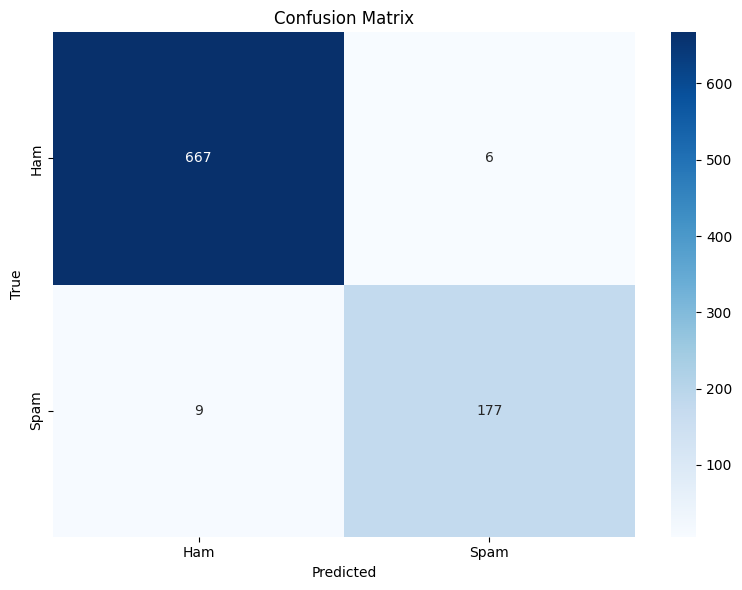

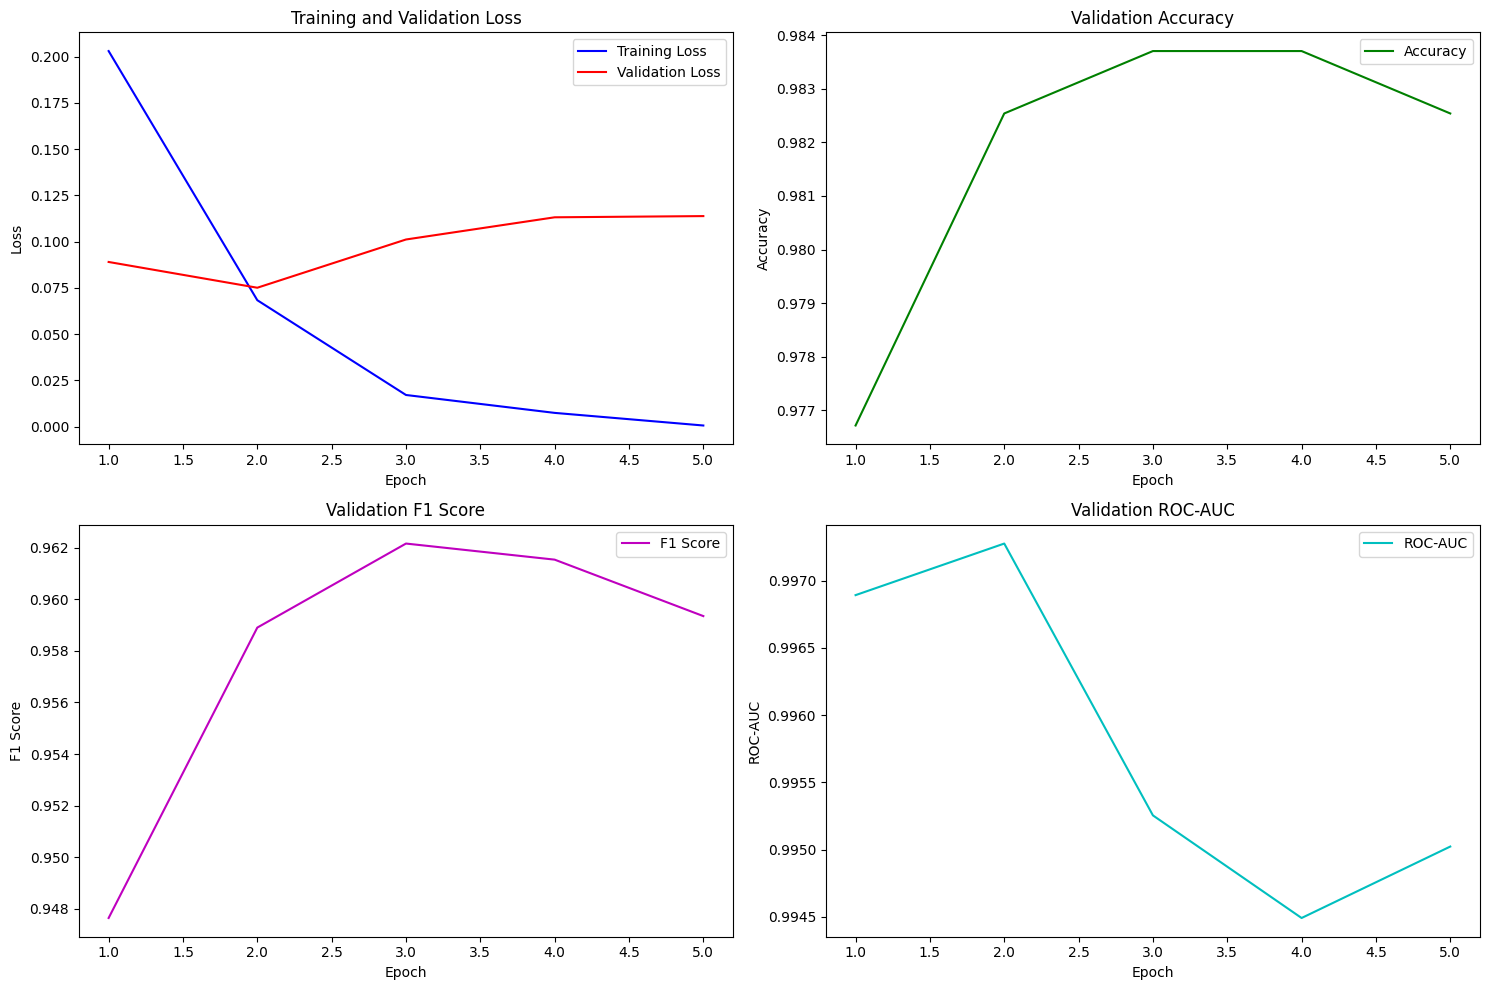

In [11]:
val_loss, acc, prec, rec, f1, auc, preds, labels, val_probs = evaluate(model, val_loader, device)

print("Final Metrics")
print("---")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1: {f1:.4f}")
print(f"ROC-AUC: {auc:.4f}")
print()
print(classification_report(labels, preds, target_names=['Ham', 'Spam']))

val_total = len(labels)
val_ham = int((np.array(labels) == 0).sum())
val_spam = val_total - val_ham
print(f"Validation totals -> Total: {val_total}, Ham: {val_ham}, Spam: {val_spam}")

cm = confusion_matrix(labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Training history plots
if stats:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    epochs_range = [stat['epoch'] for stat in stats]

    axes[0, 0].plot(epochs_range, [stat['train_loss'] for stat in stats], 'b-', label='Training Loss')
    axes[0, 0].plot(epochs_range, [stat['val_loss'] for stat in stats], 'r-', label='Validation Loss')
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()

    axes[0, 1].plot(epochs_range, [stat['acc'] for stat in stats], 'g-', label='Accuracy')
    axes[0, 1].set_title('Validation Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()

    axes[1, 0].plot(epochs_range, [stat['f1'] for stat in stats], 'm-', label='F1 Score')
    axes[1, 0].set_title('Validation F1 Score')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('F1 Score')
    axes[1, 0].legend()

    axes[1, 1].plot(epochs_range, [stat['auc'] for stat in stats], 'c-', label='ROC-AUC')
    axes[1, 1].set_title('Validation ROC-AUC')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('ROC-AUC')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

Validation label distribution -> {'Ham': 673, 'Spam': 186}
Validation prediction distribution -> {'Ham': 676, 'Spam': 183}


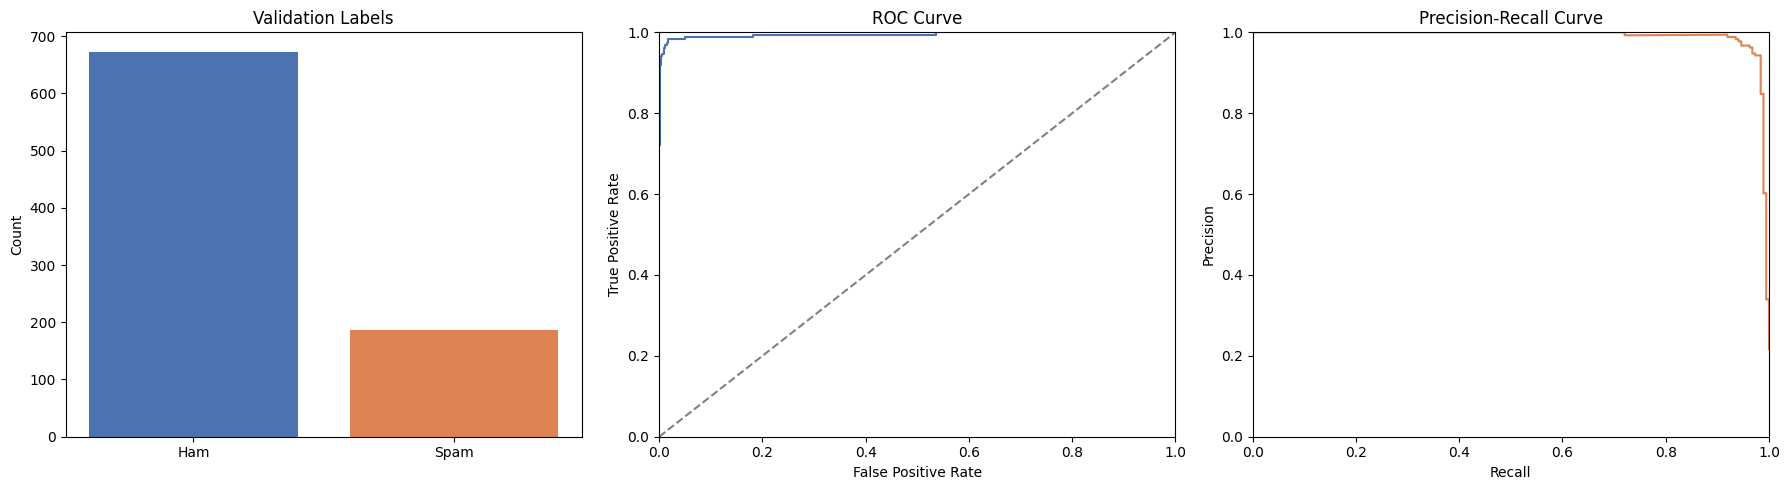

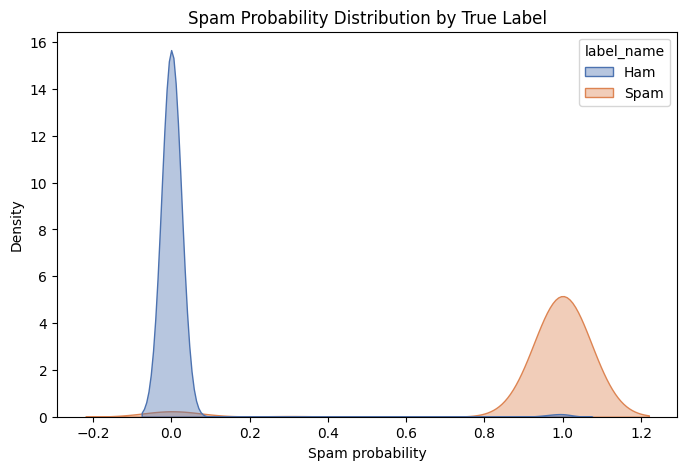

In [12]:
# Additional validation visualizations
val_counts = pd.Series(labels).value_counts().rename({0: 'Ham', 1: 'Spam'})
pred_counts = pd.Series(preds).value_counts().rename({0: 'Ham', 1: 'Spam'})

print("Validation label distribution ->", val_counts.to_dict())
print("Validation prediction distribution ->", pred_counts.to_dict())

fpr, tpr, _ = roc_curve(labels, val_probs)
prec_curve, rec_curve, _ = precision_recall_curve(labels, val_probs)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].bar(val_counts.index, val_counts.values, color=['#4c72b0', '#dd8452'])
axes[0].set_title('Validation Labels')
axes[0].set_ylabel('Count')

axes[1].plot(fpr, tpr, color='#4c72b0')
axes[1].plot([0, 1], [0, 1], '--', color='gray')
axes[1].set_title('ROC Curve')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])

axes[2].plot(rec_curve, prec_curve, color='#dd8452')
axes[2].set_title('Precision-Recall Curve')
axes[2].set_xlabel('Recall')
axes[2].set_ylabel('Precision')
axes[2].set_xlim([0, 1])
axes[2].set_ylim([0, 1])

plt.tight_layout()
plt.savefig('validation_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Probability distribution by true label
prob_df = pd.DataFrame({'prob': val_probs, 'label': labels})
prob_df['label_name'] = prob_df['label'].map({0: 'Ham', 1: 'Spam'})
plt.figure(figsize=(8, 5))
sns.kdeplot(data=prob_df, x='prob', hue='label_name', fill=True, common_norm=False, palette=['#4c72b0', '#dd8452'], alpha=0.4)
plt.title('Spam Probability Distribution by True Label')
plt.xlabel('Spam probability')
plt.ylabel('Density')
plt.savefig('validation_probability_density.png', dpi=300, bbox_inches='tight')
plt.show()

Tokenizing:   0%|          | 0/6448 [00:00<?, ?it/s]

Predicting:   0%|          | 0/403 [00:00<?, ?it/s]

Test summary
---
{'Ham': 5150, 'Spam': 1298}


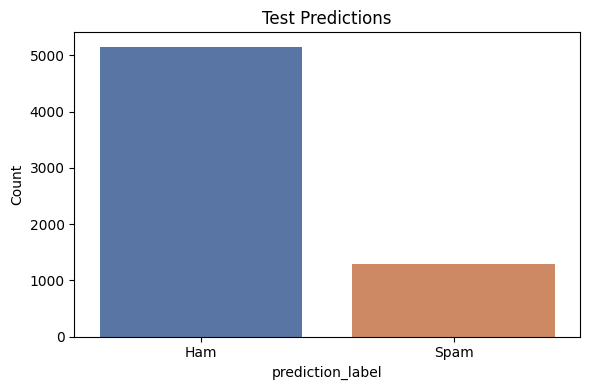

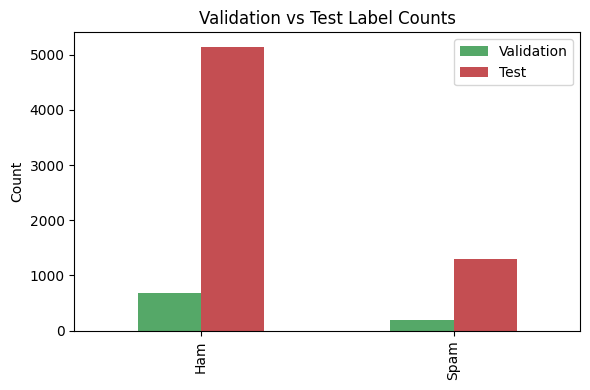

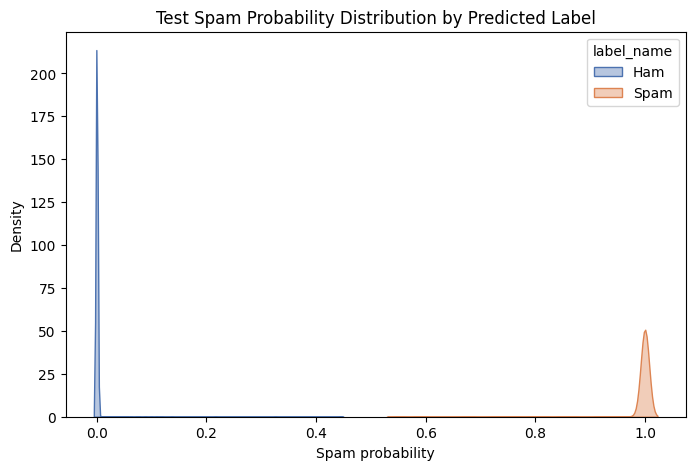

,text,prediction_label,spam_probability,confidence
0,message,ham,0.000089,0.999911
1,"SMS SERVICES. for your inclusive text credits, pls goto www.comuk.net login= ***** unsubscribe with STOP. no extra c...",spam,0.999944,0.999944
2,ILL B DOWN SOON,ham,0.000064,0.999936
3,"Subject: vastar / big thicket\r\nanita ,\r\nper our meeting yesterday , i have set up the necessary usage tickets . ...",ham,0.000040,0.999960
4,Subject: point change for deals\r\nfyi - - - i changed points on this deal from pgtt - teco waha 18002800 to pgtt - ...,ham,0.000035,0.999965
5,"Subject: hpl nom for may 25 , 2001\r\n( see attached file : hplno 525 . xls )\r\n- hplno 525 . xls",ham,0.000045,0.999955
6,Subject: healthy reproductive analysis\r\ni just wanted to write and thank you for spur - m .\r\ni suffered from poo...,spam,0.999656,0.999656
7,Anytime lor...,ham,0.000041,0.999959
8,Subject: looking for cheap high - quality software ? teethe minus\r\naverting mutterer profane\r\naltruism oleomarga...,spam,0.999938,0.999938
9,"Pls send me a comprehensive mail about who i'm paying, when and how much.",ham,0.000036,0.999964


In [14]:
test_file = os.path.join(dataset_dir, 'spam_test.csv')
test_data = pd.read_csv(test_file, header=None, names=['text'])
test_texts = test_data['text'].apply(clean_text).values
test_ids, test_masks = tokenize(test_texts, tokenizer)
test_dataset = SpamDataset(test_ids, test_masks, torch.zeros(len(test_texts)))  # Dummy labels for dataset
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

model.eval()
predictions = []
probabilities = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Predicting"):
        outputs = model(input_ids=batch['input_ids'].to(device), attention_mask=batch['attention_mask'].to(device))
        probs = torch.softmax(outputs.logits, dim=1)
        predictions.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
        probabilities.extend(probs[:, 1].cpu().numpy())  # Spam class probability

results = pd.DataFrame({
    'text': test_data['text'].values,
    'text_clean': test_texts,
    'prediction': predictions,
    'prediction_label': ['spam' if p == 1 else 'ham' for p in predictions],
    'spam_probability': probabilities,
    'confidence': [max(1-prob, prob) for prob in probabilities]  # Confidence = max(prob, 1-prob)
})

# Test set visualizations and summary
print("Test summary")
print("---")
test_counts = results['prediction_label'].value_counts().reindex(['ham', 'spam'], fill_value=0)
print(test_counts.rename(index={'ham': 'Ham', 'spam': 'Spam'}).to_dict())

plt.figure(figsize=(6, 4))
sns.barplot(x=test_counts.index.map({'ham': 'Ham', 'spam': 'Spam'}), y=test_counts.values, palette=['#4c72b0', '#dd8452'])
plt.title('Test Predictions')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('test_prediction_counts.png', dpi=300, bbox_inches='tight')
plt.show()

# Compare validation vs test distributions
val_counts = pd.Series(labels).value_counts().rename({0: 'Ham', 1: 'Spam'})
test_counts_named = test_counts.rename(index={'ham': 'Ham', 'spam': 'Spam'})
compare_df = pd.DataFrame({'Validation': val_counts, 'Test': test_counts_named}).fillna(0)
compare_df.plot(kind='bar', figsize=(6, 4), color=['#55a868', '#c44e52'])
plt.title('Validation vs Test Label Counts')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('validation_vs_test_counts.png', dpi=300, bbox_inches='tight')
plt.show()

# Probability distribution for test predictions
test_prob_df = pd.DataFrame({'prob': results['spam_probability'], 'label': results['prediction_label'].map({'ham': 0, 'spam': 1})})
test_prob_df['label_name'] = test_prob_df['label'].map({0: 'Ham', 1: 'Spam'})
plt.figure(figsize=(8, 5))
sns.kdeplot(data=test_prob_df, x='prob', hue='label_name', fill=True, common_norm=False, palette=['#4c72b0', '#dd8452'], alpha=0.4)
plt.title('Test Spam Probability Distribution by Predicted Label')
plt.xlabel('Spam probability')
plt.ylabel('Density')
plt.savefig('test_probability_density.png', dpi=300, bbox_inches='tight')
plt.show()

# Display a few sample predictions
pd.options.display.max_colwidth = 120
display(results[['text', 'prediction_label', 'spam_probability', 'confidence']].head(10))

Tokenizing:   0%|          | 0/6448 [00:00<?, ?it/s]

Predicting:   0%|          | 0/403 [00:00<?, ?it/s]

Test samples: 6448
Ham: 5150, Spam: 1298

Test summary
---
{'Ham': 5150, 'Spam': 1298}


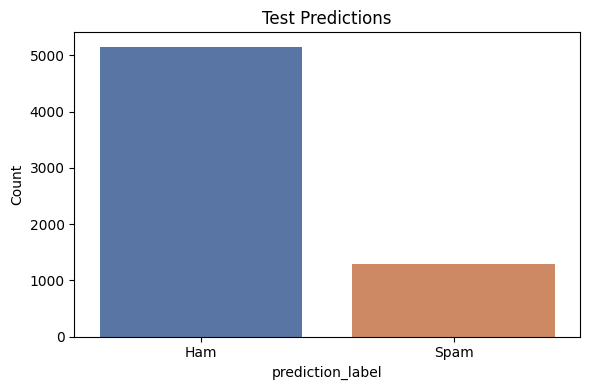

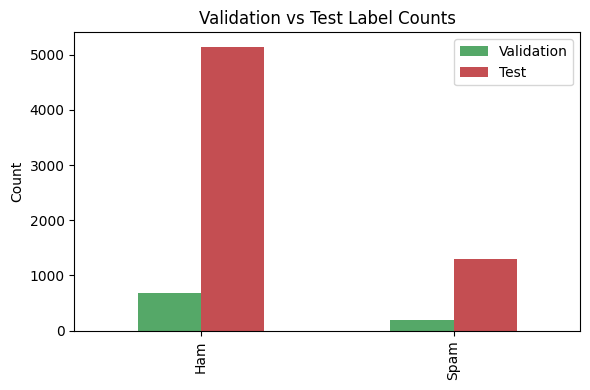

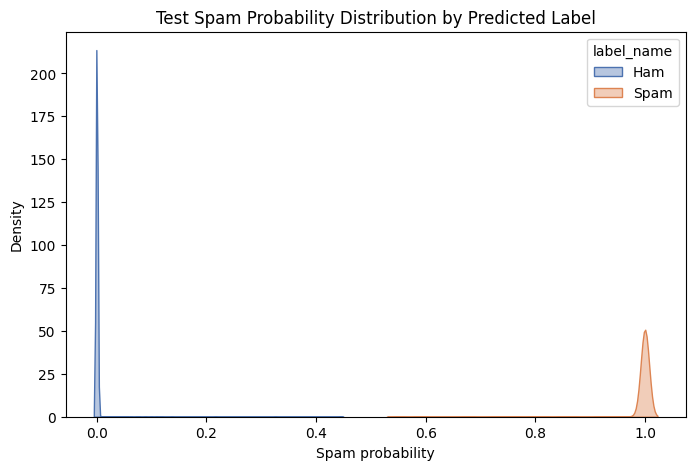

,text,prediction_label,spam_probability,confidence
0,message,ham,0.000089,0.999911
1,"SMS SERVICES. for your inclusive text credits, pls goto www.comuk.net login= ***** unsubscribe with STOP. no extra c...",spam,0.999944,0.999944
2,ILL B DOWN SOON,ham,0.000064,0.999936
3,"Subject: vastar / big thicket\r\nanita ,\r\nper our meeting yesterday , i have set up the necessary usage tickets . ...",ham,0.000040,0.999960
4,Subject: point change for deals\r\nfyi - - - i changed points on this deal from pgtt - teco waha 18002800 to pgtt - ...,ham,0.000035,0.999965
5,"Subject: hpl nom for may 25 , 2001\r\n( see attached file : hplno 525 . xls )\r\n- hplno 525 . xls",ham,0.000045,0.999955
6,Subject: healthy reproductive analysis\r\ni just wanted to write and thank you for spur - m .\r\ni suffered from poo...,spam,0.999656,0.999656
7,Anytime lor...,ham,0.000041,0.999959
8,Subject: looking for cheap high - quality software ? teethe minus\r\naverting mutterer profane\r\naltruism oleomarga...,spam,0.999938,0.999938
9,"Pls send me a comprehensive mail about who i'm paying, when and how much.",ham,0.000036,0.999964


In [15]:
test_file = os.path.join(dataset_dir, 'spam_test.csv')
test_data = pd.read_csv(test_file, header=None, names=['text'])
test_texts = test_data['text'].apply(clean_text).values
test_ids, test_masks = tokenize(test_texts, tokenizer)
test_dataset = SpamDataset(test_ids, test_masks, torch.zeros(len(test_texts)))  # Dummy labels for dataset
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

model.eval()
predictions = []
probabilities = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Predicting"):
        outputs = model(input_ids=batch['input_ids'].to(device), attention_mask=batch['attention_mask'].to(device))
        probs = torch.softmax(outputs.logits, dim=1)
        predictions.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
        probabilities.extend(probs[:, 1].cpu().numpy())  # Spam class probability

results = pd.DataFrame({
    'text': test_data['text'].values,
    'text_clean': test_texts,
    'prediction': predictions,
    'prediction_label': ['spam' if p == 1 else 'ham' for p in predictions],
    'spam_probability': probabilities,
    'confidence': [max(1-prob, prob) for prob in probabilities]  # Confidence = max(prob, 1-prob)
})

print(f"Test samples: {len(results)}")
print(f"Ham: {sum(results['prediction'] == 0)}, Spam: {sum(results['prediction'] == 1)}")

# Test set visualizations and comparisons
print("\nTest summary")
print("---")
test_counts = results['prediction_label'].value_counts().reindex(['ham', 'spam'], fill_value=0)
print(test_counts.rename(index={'ham': 'Ham', 'spam': 'Spam'}).to_dict())

plt.figure(figsize=(6, 4))
sns.barplot(x=test_counts.index.map({'ham': 'Ham', 'spam': 'Spam'}), y=test_counts.values, palette=['#4c72b0', '#dd8452'])
plt.title('Test Predictions')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('test_prediction_counts.png', dpi=300, bbox_inches='tight')
plt.show()

# Compare validation vs test distributions
val_counts_named = pd.Series(labels).value_counts().rename({0: 'Ham', 1: 'Spam'})
test_counts_named = test_counts.rename(index={'ham': 'Ham', 'spam': 'Spam'})
compare_df = pd.DataFrame({'Validation': val_counts_named, 'Test': test_counts_named}).fillna(0)
compare_df.plot(kind='bar', figsize=(6, 4), color=['#55a868', '#c44e52'])
plt.title('Validation vs Test Label Counts')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('validation_vs_test_counts.png', dpi=300, bbox_inches='tight')
plt.show()

# Probability distribution for test predictions
test_prob_df = pd.DataFrame({'prob': results['spam_probability'], 'label': results['prediction_label'].map({'ham': 0, 'spam': 1})})
test_prob_df['label_name'] = test_prob_df['label'].map({0: 'Ham', 1: 'Spam'})
plt.figure(figsize=(8, 5))
sns.kdeplot(data=test_prob_df, x='prob', hue='label_name', fill=True, common_norm=False, palette=['#4c72b0', '#dd8452'], alpha=0.4)
plt.title('Test Spam Probability Distribution by Predicted Label')
plt.xlabel('Spam probability')
plt.ylabel('Density')
plt.savefig('test_probability_density.png', dpi=300, bbox_inches='tight')
plt.show()

# Display a few sample predictions
pd.options.display.max_colwidth = 120
display(results[['text', 'prediction_label', 'spam_probability', 'confidence']].head(10))

In [16]:
output_file = 'spam_predictions.csv'
results.to_csv(output_file, index=False)

# Summary with essential columns only
summary_results = results[['prediction_label', 'spam_probability', 'confidence']].copy()
summary_results.to_csv('spam_predictions_summary.csv', index=False)

# Output labels only
output_labels = results[['prediction_label']].copy()
output_labels.to_csv('output_labels.csv', index=False)

training_df = pd.DataFrame(stats)
training_df.to_csv('training_statistics.csv', index=False)

val_summary = pd.DataFrame({
    'metric': ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
    'value': [acc, prec, rec, f1, auc]
})
val_summary.to_csv('validation_metrics.csv', index=False)

# Generate model report with configuration and metrics
report = f"""BERT Spam Email Detector - Model Report\n

Model Configuration:
- Base Model: bert-base-uncased
- Number of Classes: 2 (Ham=0, Spam=1)
- Max Sequence Length: 128
- Training Parameters: lr={lr}, epochs={epochs}, batch_size={batch_size}

Dataset Information:
- Total Training Samples: {len(X_train)}
- Total Validation Samples: {len(X_val)}
- Training Ham/Spam Ratio: {np.bincount(y_train)[0]}/{np.bincount(y_train)[1]}
- Validation Ham/Spam Ratio: {np.bincount(y_val)[0]}/{np.bincount(y_val)[1]}

Final Performance Metrics:
- Accuracy: {acc:.4f}
- Precision: {prec:.4f}
- Recall: {rec:.4f}
- F1 Score: {f1:.4f}
- ROC-AUC: {auc:.4f}

Test Set Predictions:
- Total Test Emails: {len(results)}
- Predicted Ham: {sum(results['prediction'] == 0)}
- Predicted Spam: {sum(results['prediction'] == 1)}
- Average Confidence: {results['confidence'].mean():.4f}

Files Generated:
- Predictions: {output_file}
- Summary: spam_predictions_summary.csv
- Output Labels: output_labels.csv
- Training Stats: training_statistics.csv
- Validation Metrics: validation_metrics.csv
- Confusion Matrix: confusion_matrix.png
- Training History: training_history.png
- Validation Curves: validation_curves.png
- Validation Probability Density: validation_probability_density.png
- Test Prediction Counts: test_prediction_counts.png
- Validation vs Test Counts: validation_vs_test_counts.png
- Test Probability Density: test_probability_density.png
"""

with open('model_report.txt', 'w') as f:
    f.write(report)

print("Saved: spam_predictions.csv, spam_predictions_summary.csv, output_labels.csv, training_statistics.csv, model_report.txt")

if IN_COLAB:
    print("\\nDownloading results")
    print("---")
    import zipfile
    from google.colab import files

    # Package all results into zip file
    with zipfile.ZipFile('results.zip', 'w') as zipf:
        for f in ['spam_predictions.csv', 'spam_predictions_summary.csv', 'output_labels.csv',
                  'training_statistics.csv', 'validation_metrics.csv', 'model_report.txt',
                  'confusion_matrix.png', 'training_history.png',
                  'validation_curves.png', 'validation_probability_density.png',
                  'test_prediction_counts.png', 'validation_vs_test_counts.png',
                  'test_probability_density.png']:
            if os.path.exists(f):
                zipf.write(f)

    files.download('results.zip')
    print("Downloaded: results.zip")

Saved: spam_predictions.csv, spam_predictions_summary.csv, output_labels.csv, training_statistics.csv, model_report.txt
\nDownloading results
---


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: results.zip
